In [1]:
import tensorflow as tf
import keras
from keras.models import Model, Sequential
from keras.layers import Conv2D, Activation, Input, Add, MaxPooling2D, Dense, Flatten, Dropout


In [2]:
train_dir = r"C:\Users\dani\Documents\face-emotion-detection\FER-13\train" # Directory containing the training data
test_dir = r"C:\Users\dani\Documents\face-emotion-detection\FER-13\test"  # Directory containing the validation data

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    shear_range = 0.3,        # Randomly shift the width of images by up to 10%
    zoom_range = 0.3,       # Randomly shift the height of images by up to 10%
    rotation_range = 30,
    horizontal_flip = True,         # Flip images horizontally at random
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2,          # Set aside 20% of the data for validation
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,           # Directory containing the training data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 32,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "training",              # Uses the training subset of the data
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory = test_dir,            # Directory containing the validation data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 32,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "validation",           # Uses the validation subset of the data
    shuffle=True
)

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [5]:
class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']

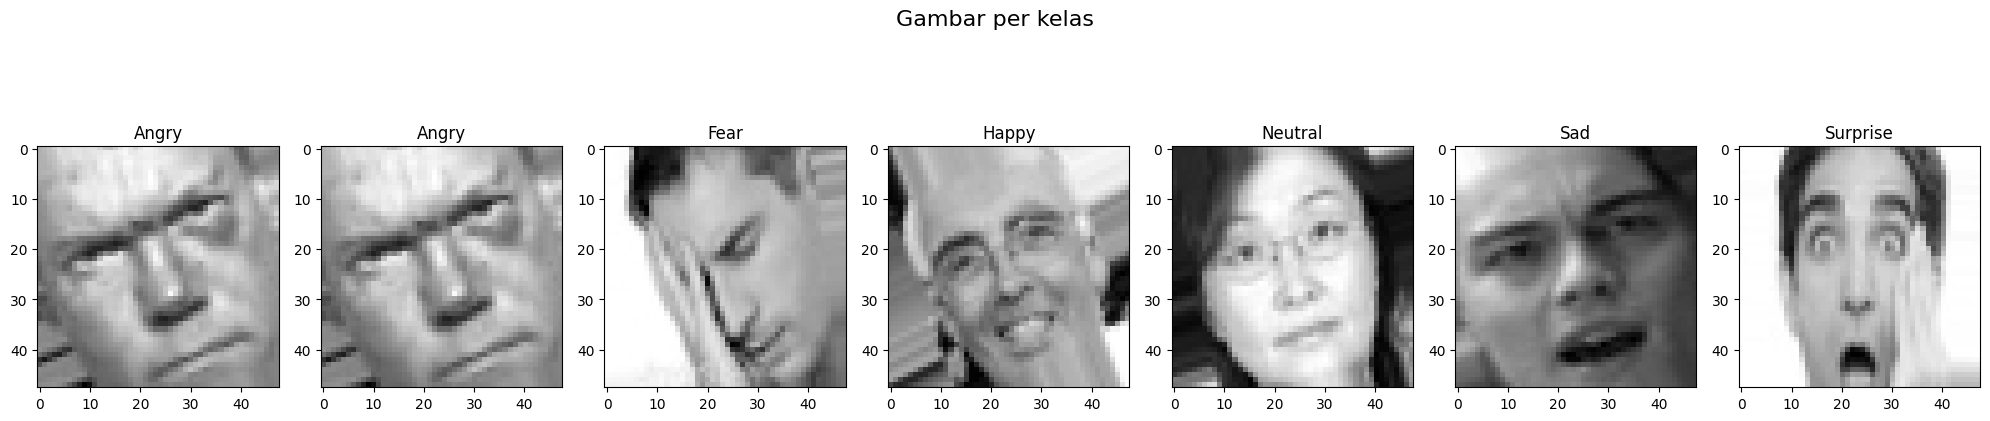

In [6]:
img, label = train_generator.__next__()
import random
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,7, figsize=(20, 5))
fig.suptitle("Gambar per kelas", fontsize=16)

for class_idx in range(7):
    for i in range(len(label)):
        if label[i].argmax() == class_idx:
            image = img[i]
            labl = class_labels[class_idx]
            break

    ax = axes[class_idx]
    ax.imshow(image[:,:,0], cmap='gray', )
    ax.set_title(labl)
    ax.axis('on')

plt.tight_layout()
plt.show()
        

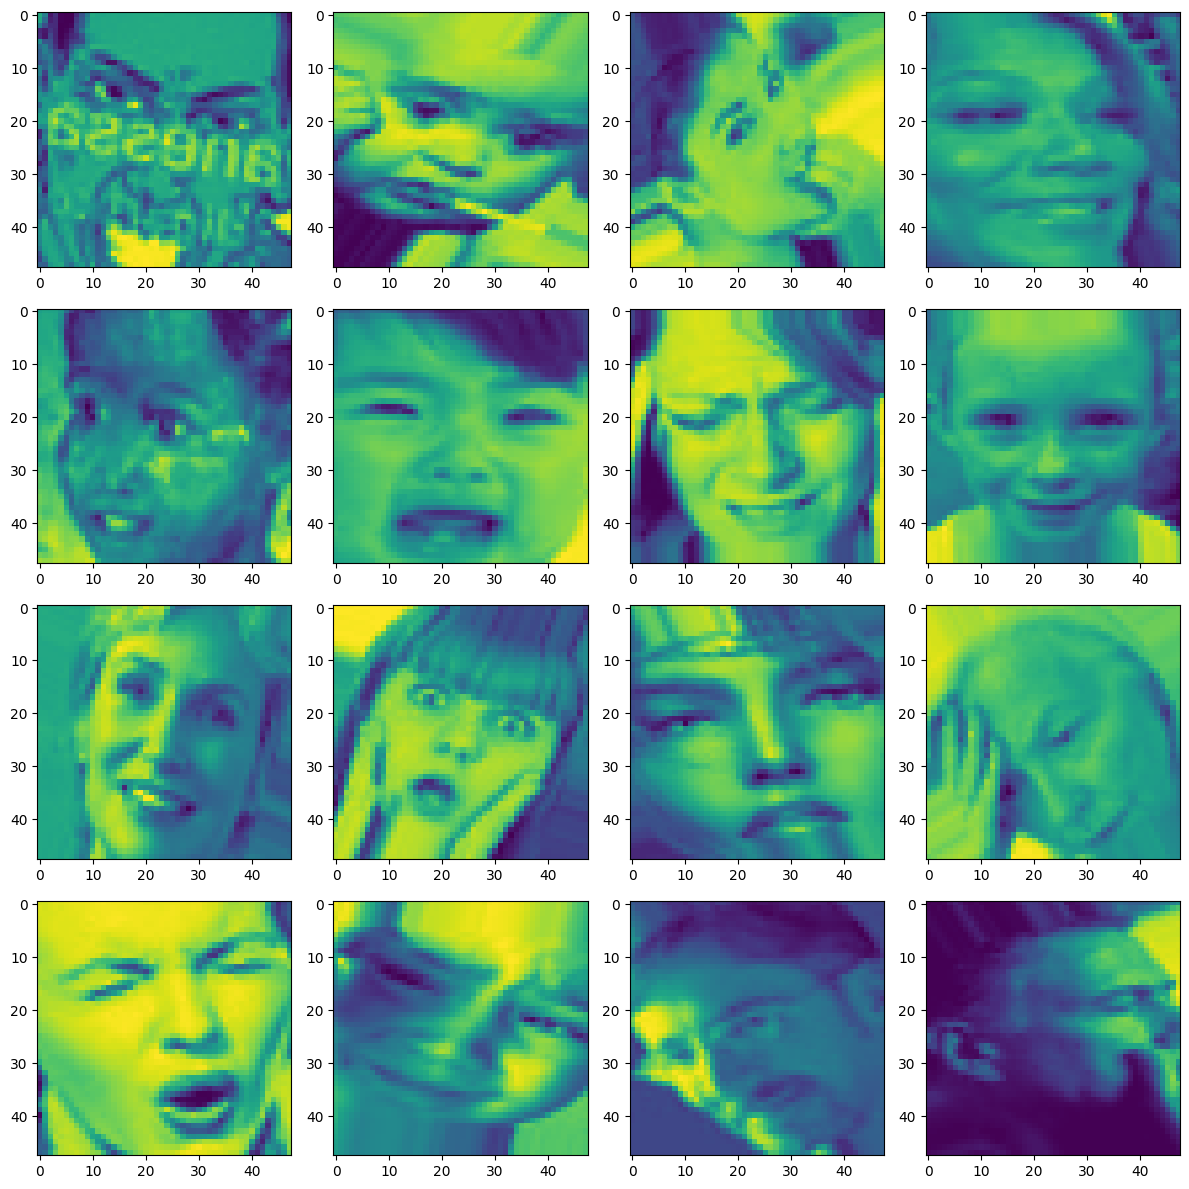

In [7]:
import matplotlib.pyplot as plt
# Fungsi untuk menampilkan gambar hasil augmentasi
def show_augmented_images(generator, num_images):
    images, labels = next(generator)  # Ambil satu batch gambar
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)  # Menampilkan 4x4 grid gambar
        plt.imshow(images[i])
        plt.axis('on')
    plt.tight_layout()
    plt.show()

# Menampilkan 16 gambar hasil augmentasi
show_augmented_images(train_generator, 16)


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_deepid_model(input_shape=(55, 47, 3), num_classes=7):
    model = models.Sequential()

    # Input layer
    model.add(layers.InputLayer(input_shape=input_shape))

    # Convolutional Layer 1
    model.add(layers.Conv2D(20, (4, 4), activation='relu', padding='valid'))
    # Max-Pooling Layer 1
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

    # Convolutional Layer 2
    model.add(layers.Conv2D(40, (3, 3), activation='relu', padding='valid'))
    # Max-Pooling Layer 2
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

    # Convolutional Layer 3
    model.add(layers.Conv2D(60, (3, 3), activation='relu', padding='valid'))
    # Max-Pooling Layer 3
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

    # Convolutional Layer 4
    model.add(layers.Conv2D(80, (2, 2), activation='relu', padding='valid'))

    # Flatten layer
    model.add(layers.Flatten())

    # Fully connected layer (DeepID features)
    model.add(layers.Dense(160, activation='relu', name='deepid_features'))

    # Output layer (Softmax)
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


In [17]:
# Build and compile the model

model = build_deepid_model()
model.load_weights('model.weights.h5')

# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# model.summary()

ValueError: A total of 2 objects could not be loaded. Example error message for object <Dense name=deepid_features, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(960, 160), Received: value.shape=(1200, 160). Target variable: <KerasVariable shape=(960, 160), dtype=float32, path=sequential_5/deepid_features/kernel>

List of objects that could not be loaded:
[<Dense name=deepid_features, built=True>, <Dense name=dense_6, built=True>]

In [21]:
import h5py

with h5py.File('deepid_keras_weights.weights.h5', 'r') as f:
    print(list(f.keys()))  # Tampilkan nama layer pada weights



['layers', 'vars']


In [12]:
from tensorflow.keras import layers, models

base_model = build_deepid_model()
for layer in base_model.layers:
    layer.trainable = False  # Bekukan lapisan dasar

x = layers.Dense(128, activation='relu')(base_model.output)
x = layers.Dropout(0.5)(x)
output = layers.Dense(7, activation='softmax')(x)

emotion_model = models.Model(inputs=base_model.input, outputs=output)

AttributeError: The layer sequential_2 has never been called and thus has no defined output.

In [12]:
from tensorflow.keras import layers, models, optimizers, callbacks


checkpoint_cb = callbacks.ModelCheckpoint(
    filepath='fer2013.keras',
    monitor='val_accuracy',
    save_best_only = True,
    verbose = 1,
    mode='auto'
)

early_stopping_cb = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='auto'
)

In [14]:
history = model.fit(
    train_generator,
    epochs=60,
    validation_data=validation_generator,
    # callbacks=[early_stopping_cb]
)

Epoch 1/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.4576 - loss: 1.4027 - val_accuracy: 0.5035 - val_loss: 1.3024
Epoch 2/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.4616 - loss: 1.3918 - val_accuracy: 0.5063 - val_loss: 1.3080
Epoch 3/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.4584 - loss: 1.3973 - val_accuracy: 0.5035 - val_loss: 1.3000
Epoch 4/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.4702 - loss: 1.3753 - val_accuracy: 0.4902 - val_loss: 1.3203
Epoch 5/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.4609 - loss: 1.3911 - val_accuracy: 0.4972 - val_loss: 1.2994
Epoch 6/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.4710 - loss: 1.3780 - val_accuracy: 0.5105 - val_loss: 1.2836
Epoch 7/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.4619 - loss: 1.3678 - val_accuracy: 0.5147 - val_loss: 1.2881
Epoch 8/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.4739 - loss: 1.3738 - 

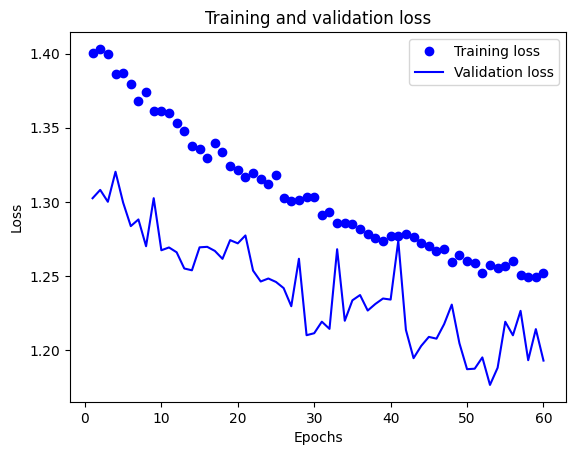

In [15]:
import matplotlib.pyplot as plt
# Plot the train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

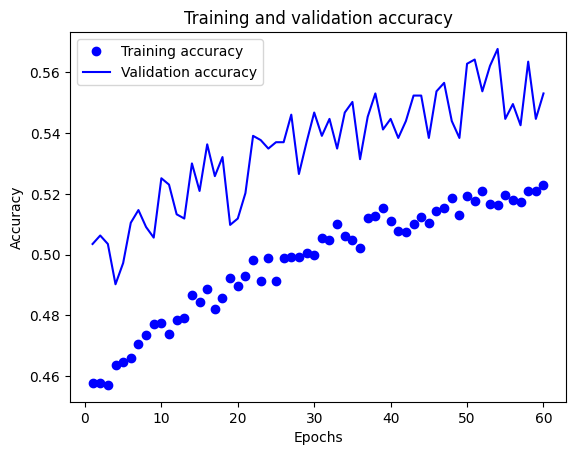

In [16]:
# Plot the train and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


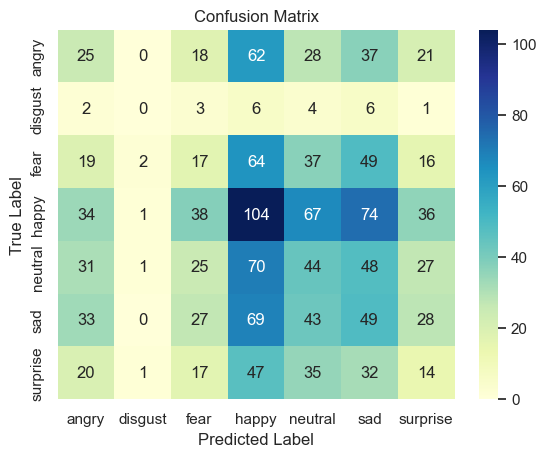

In [17]:
import seaborn as sns 
import numpy as np
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the validation set
validation_labels = validation_generator.classes
validation_pred_probs = model.predict(validation_generator)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_generator.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Evaluate the Model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss * 100:.2f}%")

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5452 - loss: 1.2530
Validation Accuracy: 55.31%
Validation Loss: 119.28%


In [19]:
model.save('deepid_60.keras')